<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🫏AnimalCLEF25 @ CVPR-FGVC & LifeCLEF🫏
</div>

<img src="https://as2.ftcdn.net/v2/jpg/06/59/72/15/1000_F_659721570_qnoEs9OKM0vnj2ja6buse5SwZvSnrhZA.jpg" alt="">

The **objective of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) challenge is to recognize individual animals—specifically lynxes, salamanders, and sea turtles—based on photographs. This notebook provides visual exploration of the dataset and introduces a baseline approach using the advanced re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384).

The dataset is divided into two parts: a *database* set and a *query* set. For each image in the query set, the task is to:

* Determine whether the animal shown is already present in the database.
* If not, the model should return the prediction `new_individual`.
* If the animal is found in the database, the model should return the corresponding individual’s ID.


<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🙌Installing the Dependencies🙌
</div>

In [1]:
!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /tmp/pip-req-build-2xo9c3ri
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /tmp/pip-req-build-2xo9c3ri
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 753d9bf64861c3e17011136b3436bf58bf02317f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.8 MB/s eta 0:00:00
  Created wheel for wildlife-datasets: filename=wildlife_datasets-1.0.6-py3-none-any.whl size=88077 sha256=069c3e4ddc87cf3fd2c6be88c2fc2cf45074bfb679a7c2e18b721485f89df14a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ncldw69w/wheels/a

<div class="alert alert-block alert-success" style="margin: 20px; padding: 20px; border-radius: 10px; border: 2px solid #4CAF50; background-color: #E6F7E2;">
    <b>📂 Dependencies:</b> Successfully installed the recquired dependencies
</div>

<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    📜IMPORTING LIBRARIES📜
</div>

In [2]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.similarity.wildfusion import SimilarityPipeline, WildFusion
from wildlife_tools.similarity.pairwise.lightglue import MatchLightGlue
from wildlife_tools.features.local import AlikedExtractor
from wildlife_tools.similarity.calibration import IsotonicCalibration

def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

2025-05-16 05:39:48.498496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747373988.714073      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747373988.786201      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We need to specify the `root`, where the data are stored and then two image transformations. 
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [3]:
root = '/kaggle/input/animal-clef-2025'
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🔥VISUALIZING THE DATA🔥
</div>

Since `AnimalCLEF2015` is the child class of `datasets.WildlifeDataset` from [wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets/blob/main/wildlife_datasets/datasets/datasets.py), it inherits all its methods and attributes. The following code specify which `transform` we want to use while loading images and that we want to load labels alongside images.

In [4]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

📌 **Plotting a sample grid** of the data. We can see that all animals in the testing sets are turtles. The column `dataset` states that all the photos come from the SeaTurtleID2022 dataset.

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025
...,...,...,...,...,...,...,...,...
15204,15204,NaN,images/SeaTurtleID2022/query/images/fecd2dfed0...,2024-06-07,NaN,loggerhead turtle,query,SeaTurtleID2022
15205,15205,NaN,images/SeaTurtleID2022/query/images/ff1a0c812b...,2023-06-28,NaN,loggerhead turtle,query,SeaTurtleID2022
15206,15206,NaN,images/SeaTurtleID2022/query/images/ff22f1cfa6...,2024-06-09,NaN,loggerhead turtle,query,SeaTurtleID2022
15207,15207,NaN,images/SeaTurtleID2022/query/images/ff5d5116d1...,2023-06-21,NaN,loggerhead turtle,query,SeaTurtleID2022


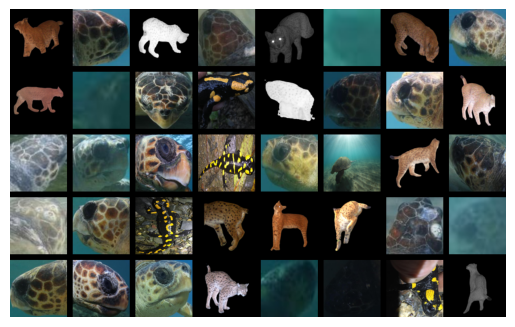

In [5]:
dataset.plot_grid()
dataset.metadata

This is confirmed by showing all datasets from which the data is composed of.

In [6]:
dataset.metadata[['dataset', 'split']].value_counts()

dataset           split   
SeaTurtleID2022   database    8729
LynxID2025        database    2957
SalamanderID2025  database    1388
LynxID2025        query        946
SalamanderID2025  query        689
SeaTurtleID2022   query        500
Name: count, dtype: int64

Now, we can plot the data of any dataset. Here we do it for the SeaTurtleID2022. The images are the same as in the query set. The goal for each image from the query set will be to determine its identity from the database (it will always be in the form `SeaTurtleID2022_t???` or to decide that it is a new individual (it is not present in the database).

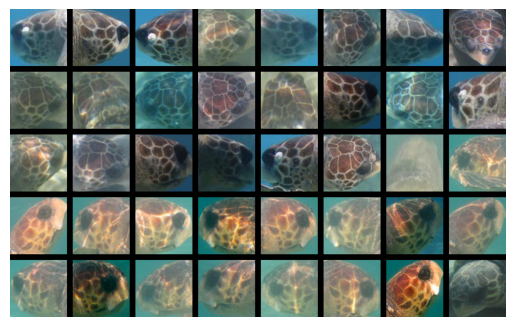

In [7]:
idx = dataset.metadata['identity'].str.startswith('SeaTurtleID2022')
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx);

<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🔥INFERENCE WITH MEGA-DESCRIPTOR🔥
</div>

Instead of training a classifier, we can just use out of the shelf pretrained models - [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). We use MegaDescriptor to extract features from all images. 

**Note:** _It is highly recommended to use the GPU acceleration._

In [8]:
# Loading the dataset
dataset = AnimalCLEF2025(root, transform=transform, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_query = len(dataset_query)

In [9]:
#Loading the model
name = 'hf-hub:BVRA/MegaDescriptor-L-384'
device = 'cuda'
model = timm.create_model(name, num_classes=0, pretrained=True)
extractor = DeepFeatures(model, device=device, batch_size=32, num_workers=0)
features_database = extractor(dataset_database)
features_query = extractor(dataset_query)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████| 67/67 [02:41<00:00,  2.42s/it]


Here we extract the similarity between the images. The similarity equals to the cosine similarity between the corresponding feature vectors. Since the cosine similarity reflects the angle between the feature vectors, high similarity means that the feature vectors are close to each other and should depict the same individual.

In [10]:
similarity = CosineSimilarity()(features_query, features_database)

For each query image we extract the closest image as predicted by MegaDescriptor. Their indices are stored in `pred_idx` and the similarity score of the top match in `pred_scores`.

In [11]:
pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

This is sufficient to perform predictions as shown below in `predictions`. However, we also need to predict whether the individual is new. We utilize the simplest idea and predict that the individual is new whenever the similarity score of the top prediction is below a certain threshold which we arbirtarily selected as 0.6. We create a submission file, which scores 30.0% on the public leaderboard.

In [12]:
new_individual = 'new_individual'
threshold = 0.6
labels = dataset_database.labels_string
predictions = labels[pred_idx]
predictions[pred_scores < threshold] = new_individual
create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv')

<div style="color:white; background-color:#C5A242; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🔥SECOND PART OF THIS NOTEBOOK🔥
</div>

In [13]:
root = '/kaggle/input/animal-clef-2025'
transform_display = T.Compose([
    T.Resize([384, 384]),
])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

transforms_aliked = T.Compose([
    T.Resize([512, 512]),
    T.ToTensor()
])

<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🔥Loading the dataset🔥
</div>

In [14]:
dataset = AnimalCLEF2025(root, load_label=True)
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
dataset_calibration = AnimalCLEF2025(root, df=dataset_database.metadata[:100], load_label=True) 

n_query = len(dataset_query)

<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🔥Loading the models🔥
</div>

In [15]:
name = 'hf-hub:BVRA/MegaDescriptor-L-384'
model = timm.create_model(name, num_classes=0, pretrained=True)
device = 'cuda'

matcher_aliked = SimilarityPipeline(
    matcher = MatchLightGlue(features='aliked', device=device, batch_size=16),
    extractor = AlikedExtractor(),
    transform = transforms_aliked,
    calibration = IsotonicCalibration()
)

matcher_mega = SimilarityPipeline(
    matcher = CosineSimilarity(),
    extractor = DeepFeatures(model=model, device=device, batch_size=16),
    transform = transform,
    calibration = IsotonicCalibration()
)

/usr/local/lib/python3.11/dist-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/aliked_lightglue.pth" to /root/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv.pth
100%|██████████| 45.4M/45.4M [00:00<00:00, 107MB/s]
Downloading: "https://github.com/Shiaoming/ALIKED/raw/main/models/aliked-n16.pth" to /root/.cache/torch/hub/checkpoints/aliked-n16.pth
100%|██████████| 2.61M/2.61M [00:00<00:00, 105MB/s]


<div style="color:white; background-color:#5642C5; padding: 10px; border-radius: 15px; font-size: 150%; font-family: Verdana; text-align:center; -webkit-text-stroke-width: 1px; -webkit-text-stroke-color: black; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);">
    🔥Calibrating the WildFusion🔥
</div>

In [16]:
wildfusion = WildFusion(calibrated_pipelines = [matcher_aliked, matcher_mega], priority_pipeline = matcher_mega)
wildfusion.fit_calibration(dataset_calibration, dataset_calibration)

# Compute WildFusion similarity
similarity = wildfusion(dataset_query, dataset_database, B=25)

pred_idx = similarity.argsort(axis=1)[:,-1]
pred_scores = similarity[range(n_query), pred_idx]

labels = dataset_database.labels_string

100%|█████████████████████████████████████████████████████████████| 818/818 [09:25<00:00,  1.45it/s]


In [17]:
for threshold in [0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6]:
    predictions = labels[pred_idx]
    predictions[pred_scores < threshold] = 'new_individual'
    create_sample_submission(dataset_query, predictions, file_name=f'sample_submission_new{int(threshold*100)}.csv')